# Predicting House Prices

**Sales prices prediction using an artificial neural network in Keras**

**Supervised Learning. Regression**

Source: Ames Housing dataset ([Kaggle website](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)).  

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ds_boost
from tensorflow import keras

log = ds_boost.logger.init(level="DEBUG", save_log=False)

ds_boost.set_parent_execution_path()
ds_boost.info_system()
sns.set_palette("GnBu_d")
# ds_boost.reproducible(seed=0) # Setup reproducible results from run to run using Keras

%matplotlib inline
%load_ext autoreload
%autoreload 2

20:34:02 - DEBUG 	 Path changed to /home/angel/DRIVE/repos/data-science-keras
20:34:02 - DEBUG 	 HARDWARE:
20:34:04 - DEBUG 	 CPU:	Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
20:34:04 - DEBUG 	 RAM:	8 GB
20:34:04 - DEBUG 	 -- No GPU  --
20:34:04 - DEBUG 	 OS:	Linux-5.15.90.1-microsoft-standard-WSL2-x86_64-with-glibc2.35
20:34:04 - DEBUG 	 ENV:	/home/angel/miniconda3/envs/ds-keras
20:34:04 - DEBUG 	 PYTHON:	3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]
20:34:04 - DEBUG 	 tensorflow                   2.13.0
20:34:04 - DEBUG 	 pandas                        2.1.1
20:34:04 - DEBUG 	 numpy                        1.24.3
20:34:04 - DEBUG 	 EXECUTION PATH: /home/angel/DRIVE/repos/data-science-keras
20:34:04 - DEBUG 	 EXECUTION DATE: Sun Sep 24 20:34:04 2023


## 1. Data Processing and Exploratory Data Analysis

In [2]:
data_path = "data/house_prices_data.csv"
target = ["SalePrice"]

df_original = pd.read_csv(data_path)

### Explore the data

In [3]:
ds_boost.info_data(df_original, target)

20:34:04 - DEBUG 	 Samples: 	1460.  	 Features: 	80
20:34:04 - DEBUG 	 Target: 	SalePrice


In [4]:
df_original.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


#### Missing values

['FireplaceQu', 'MasVnrType', 'Fence', 'Alley', 'MiscFeature', 'PoolQC']

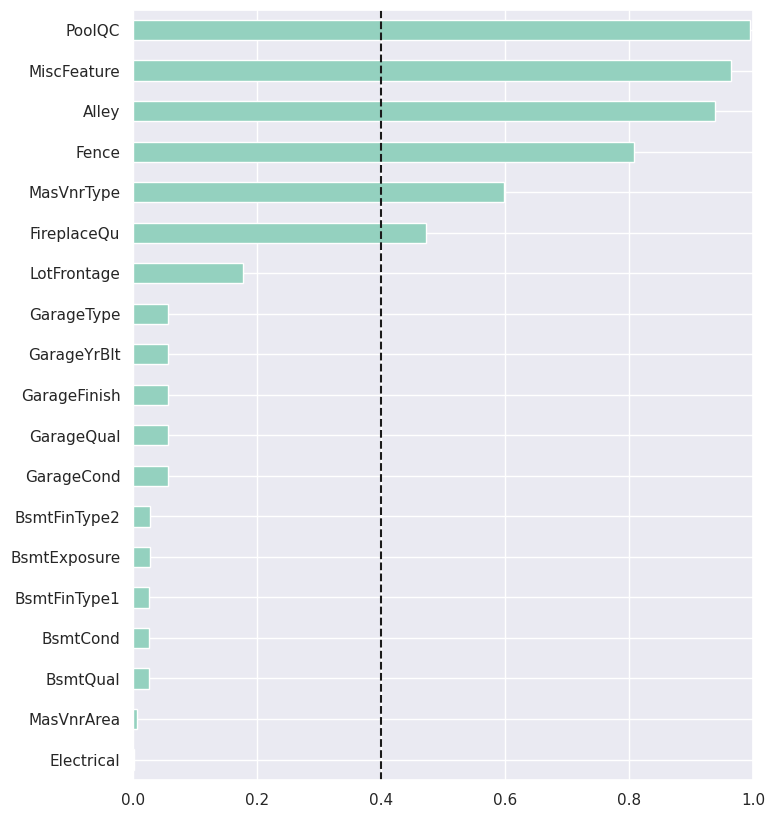

In [5]:
high_missing = ds_boost.missing(df_original, limit=0.4, plot=True)
high_missing

### Transform the data

#### Remove irrelevant features

In [6]:
df = df_original.copy()  # modified dataset

# remove non-significant and high-missing features
droplist = ["Id"] + high_missing

assert not set(droplist).intersection(set(target)), "Targets cannot be dropped"

df.drop(droplist, axis="columns", inplace=True)

#### Classify variables

Change categorical variables as dtype 'categorical' and sort columns: numerical + categorical + target

In [7]:
numerical = list(df.select_dtypes(include=[np.number]))

df = ds_boost.sort_columns_by_type(df, target, numerical=numerical)

ds_boost.get_types(df)

20:34:05 - DEBUG 	 36 numerical features: 	 ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
20:34:05 - DEBUG 	 37 categorical features: 	 ['HouseStyle', 'Functional', 'Heating', 'BsmtCond', 'Neighborhood', 'KitchenQual', 'RoofMatl', 'SaleCondition', 'LandContour', 'GarageFinish', 'Electrical', 'Street', 'Condition2', 'BsmtFinType2', 'ExterCond', 'Exterior2nd', 'Utilities', 'GarageType', 'Condition1', 'LotShape', 'BsmtExposure', 'BsmtFinType1', 'MSZoning', 'PavedDrive', 'CentralAir', 'GarageCond', 'RoofStyle', 'BldgType', 'GarageQual', 'SaleT

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageQual,SaleType,Exterior1st,LotConfig,LandSlope,ExterQual,Foundation,HeatingQC,BsmtQual,SalePrice
Type,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,...,category,category,category,category,category,category,category,category,category,float32


#### Remove low frequency values from categorical features

In [8]:
df, dict_categories = ds_boost.remove_categories(df, target, ratio=0.01)

20:34:05 - DEBUG 	 Removing 3 categories from feature HouseStyle
20:34:05 - DEBUG 	 Removing 3 categories from feature Functional
20:34:05 - DEBUG 	 Removing 4 categories from feature Heating
20:34:05 - DEBUG 	 Removing 1 categories from feature BsmtCond
20:34:05 - DEBUG 	 Removing 3 categories from feature Neighborhood
20:34:05 - DEBUG 	 Removing 7 categories from feature RoofMatl
20:34:05 - DEBUG 	 Removing 2 categories from feature SaleCondition
20:34:05 - DEBUG 	 Removing 2 categories from feature Electrical
20:34:05 - DEBUG 	 Removing 1 categories from feature Street
20:34:05 - DEBUG 	 Removing 7 categories from feature Condition2
20:34:05 - DEBUG 	 Removing 1 categories from feature BsmtFinType2
20:34:05 - DEBUG 	 Removing 2 categories from feature ExterCond
20:34:05 - DEBUG 	 Removing 6 categories from feature Exterior2nd
20:34:05 - DEBUG 	 Removing 1 categories from feature Utilities
20:34:05 - DEBUG 	 Removing 2 categories from feature GarageType
20:34:05 - DEBUG 	 Removing 4 

#### Fill missing values
Numerical -> median, categorical -> mode

In [9]:
df = ds_boost.fill_simple(df, target)

### Visualize the data

#### Target vs some significant features

(34900.0, 600000.0)

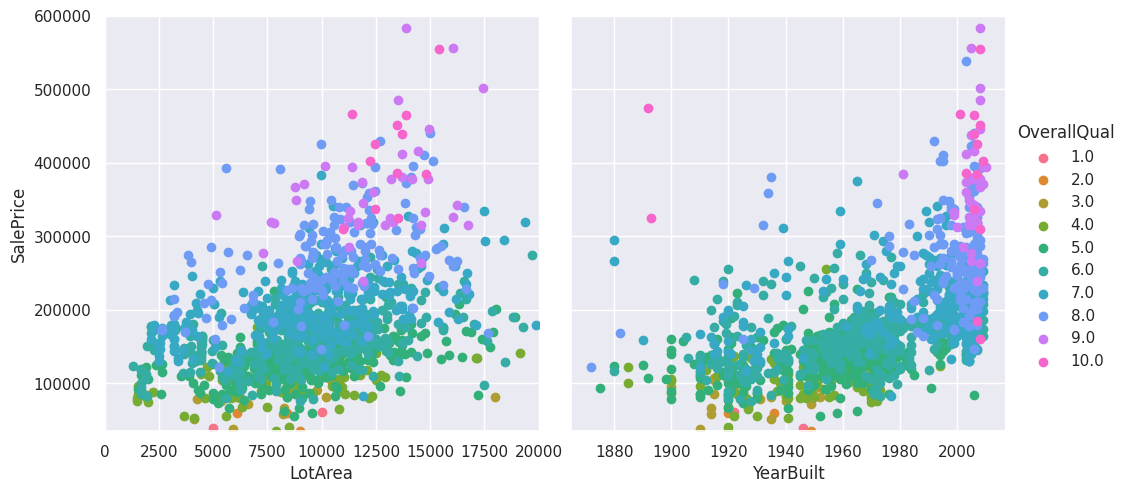

In [10]:
g = sns.PairGrid(df, y_vars=["SalePrice"], x_vars=["LotArea", "YearBuilt"], height=5, hue="OverallQual")
g.map(plt.scatter).add_legend()
g.axes[0, 0].set_xlim(0, 20000)
plt.ylim(df["SalePrice"].min(), 600000)

Lower sale prices are usually found in very low overall quality houses, with less dependency on its size and the year of construction. These three features alone are insufficient to make a good price prediction.

#### Categorical features

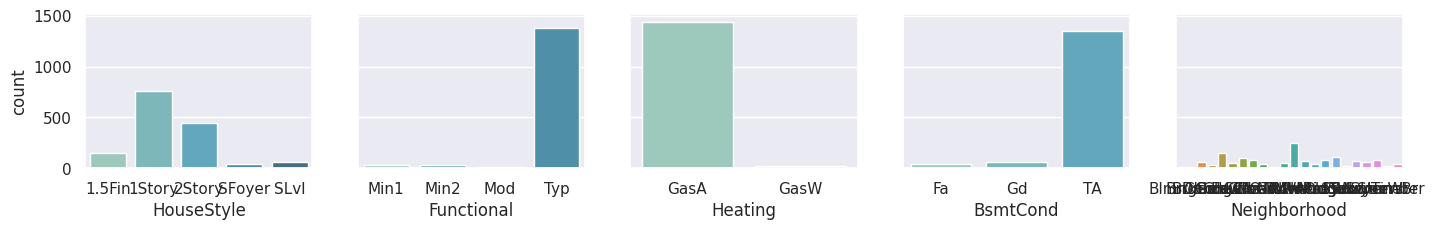

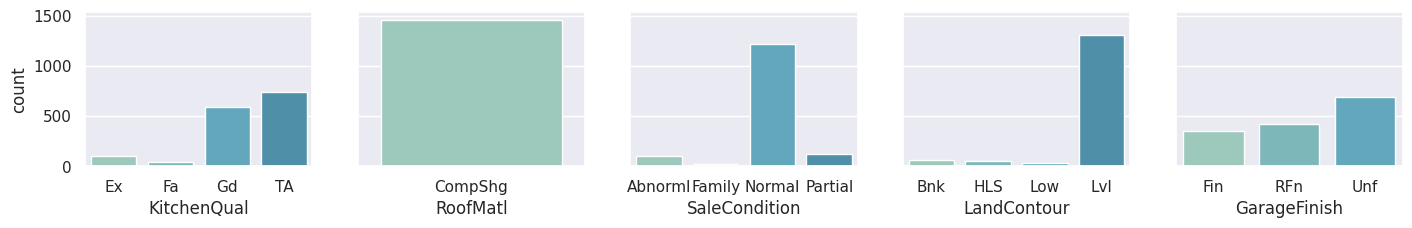

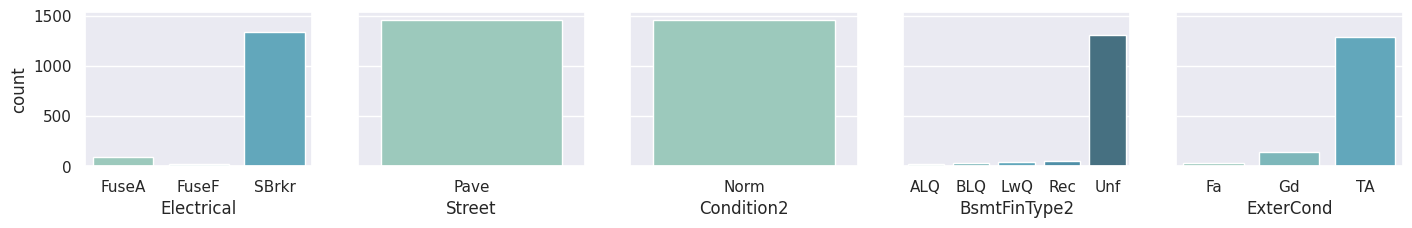

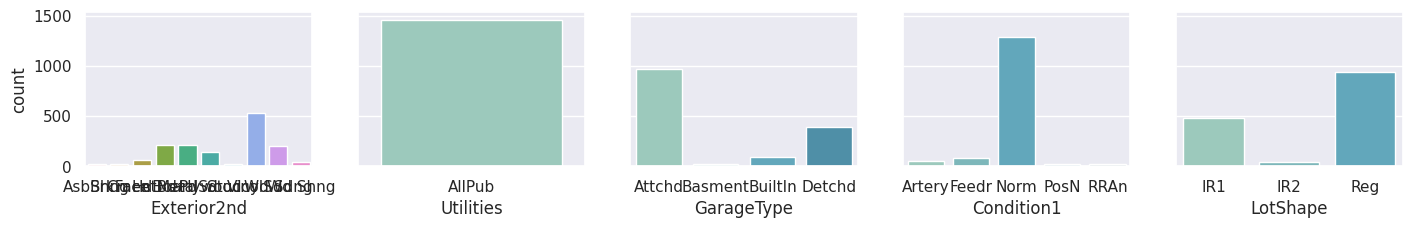

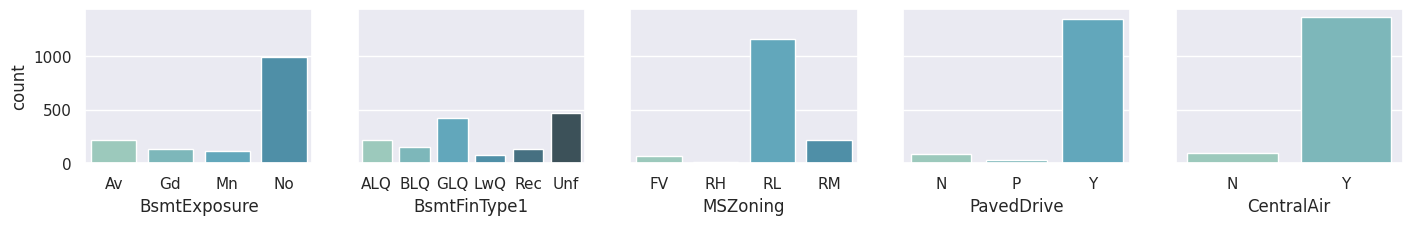

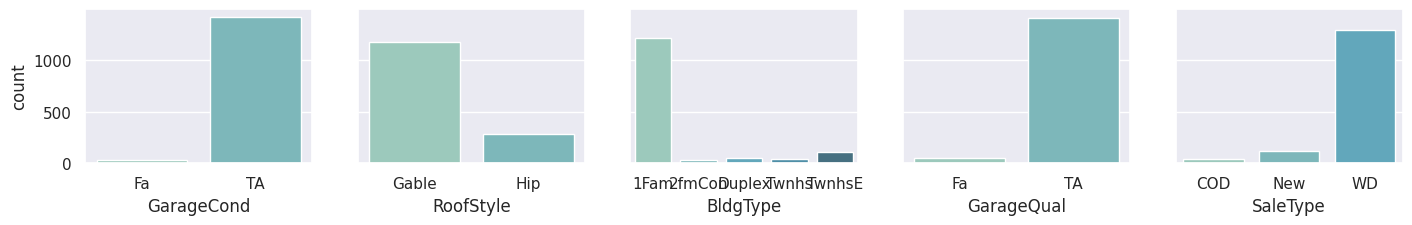

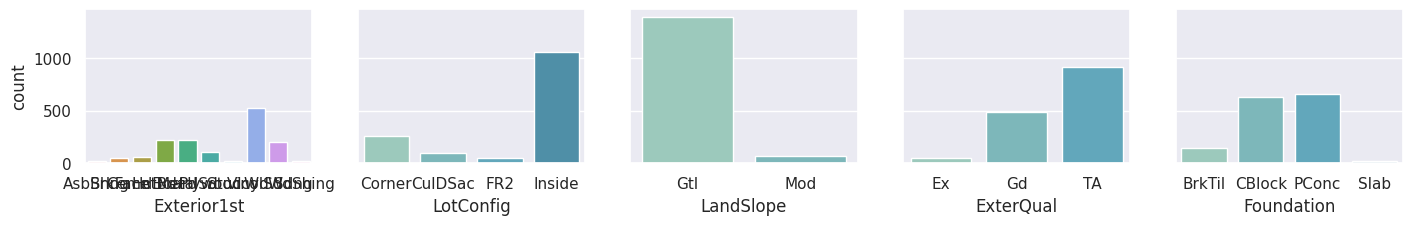

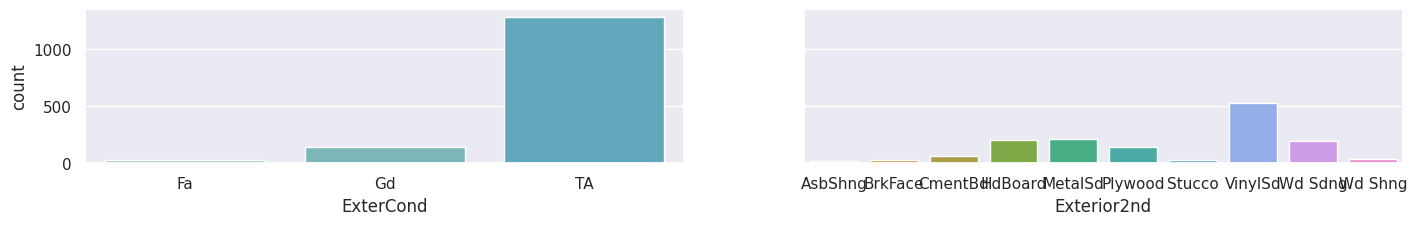

In [11]:
ds_boost.show_categorical(df, sharey=True)

#### Target vs Categorical features

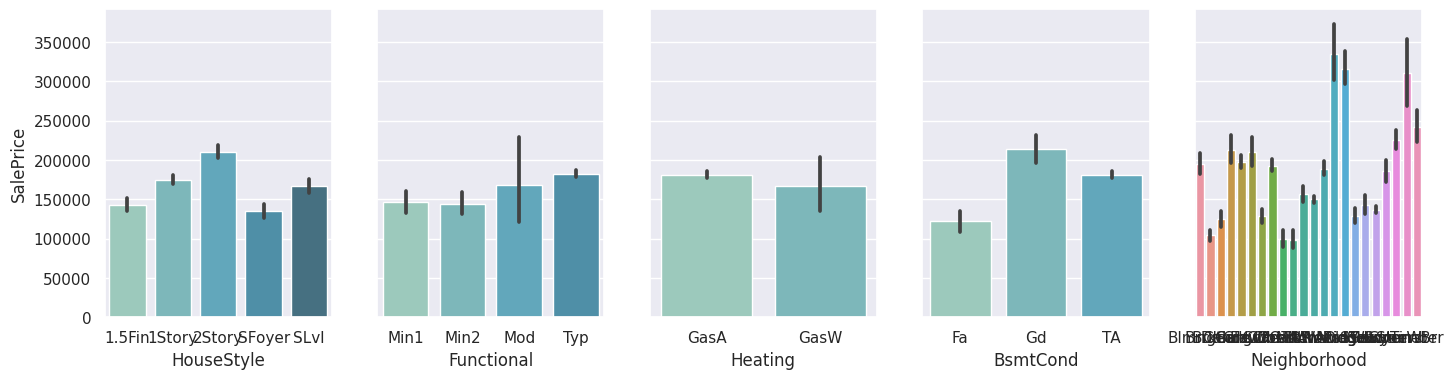

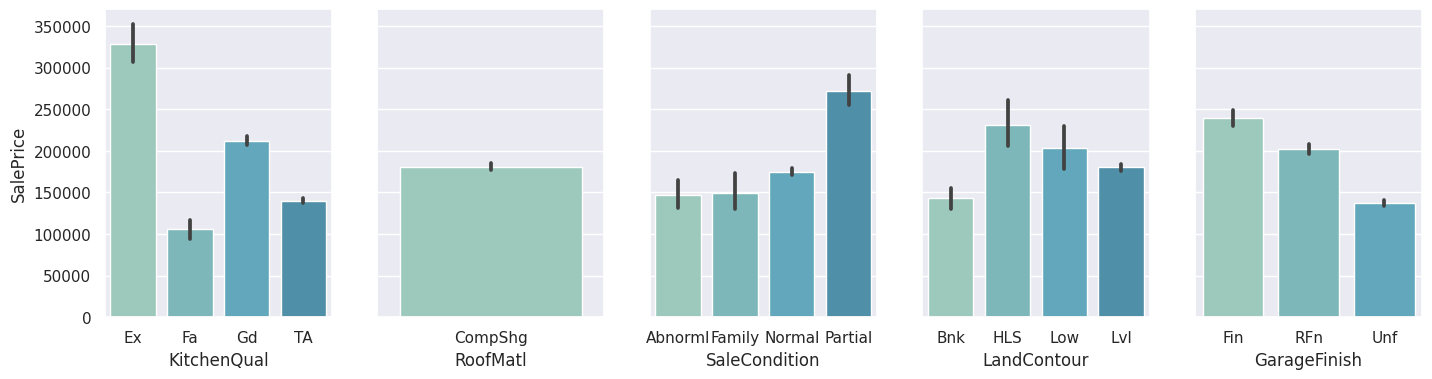

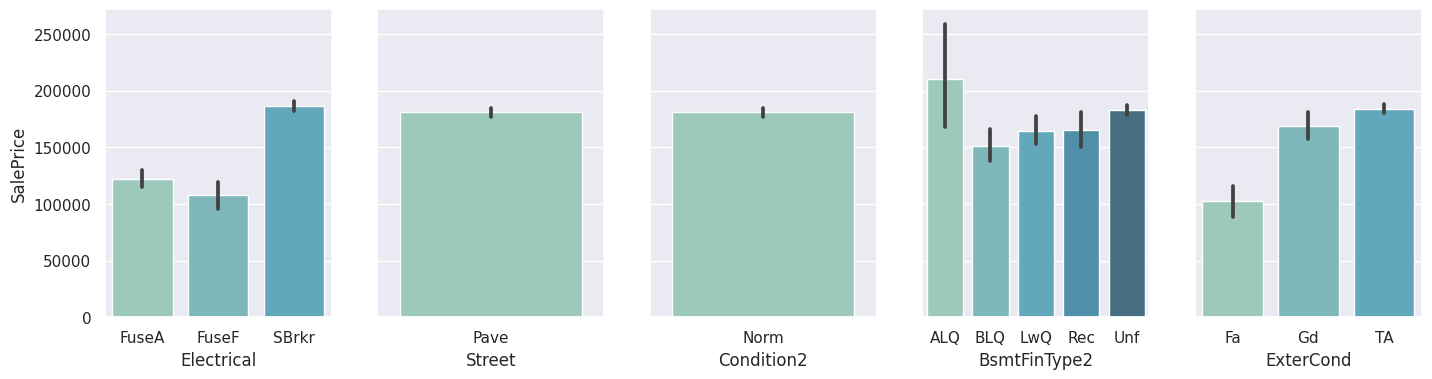

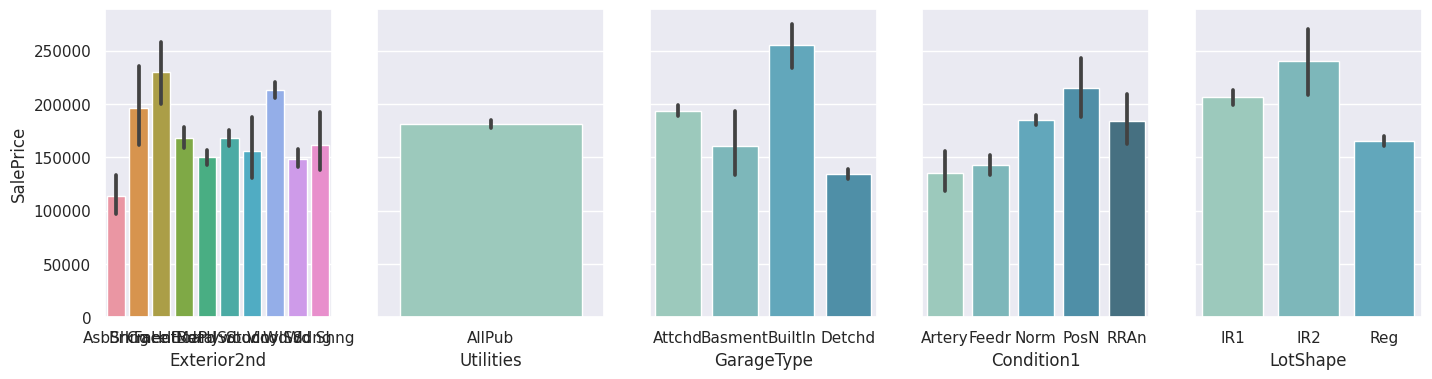

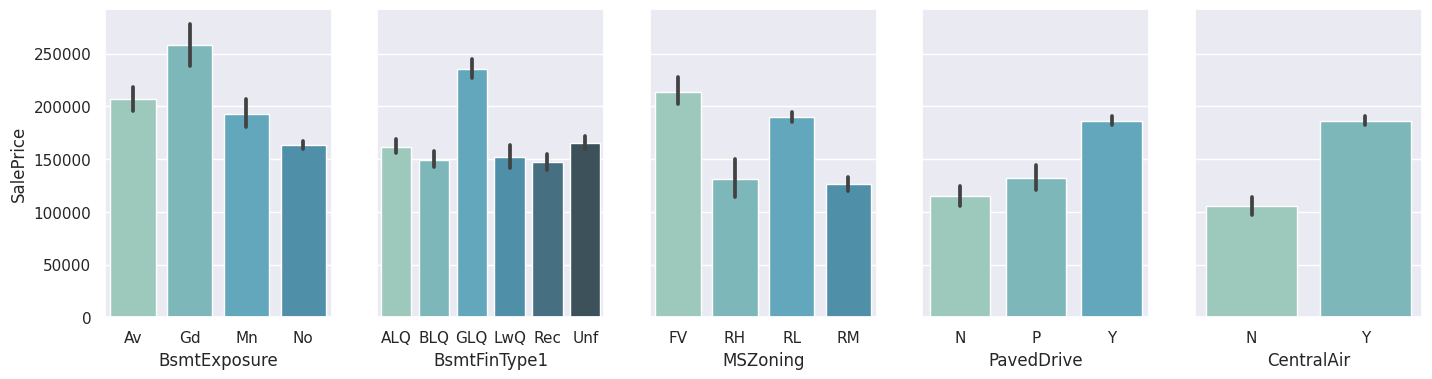

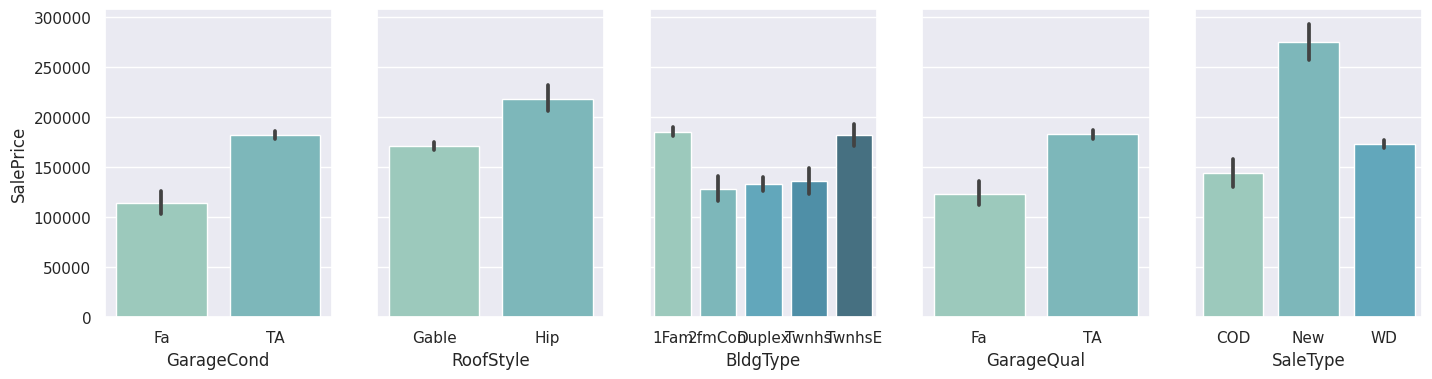

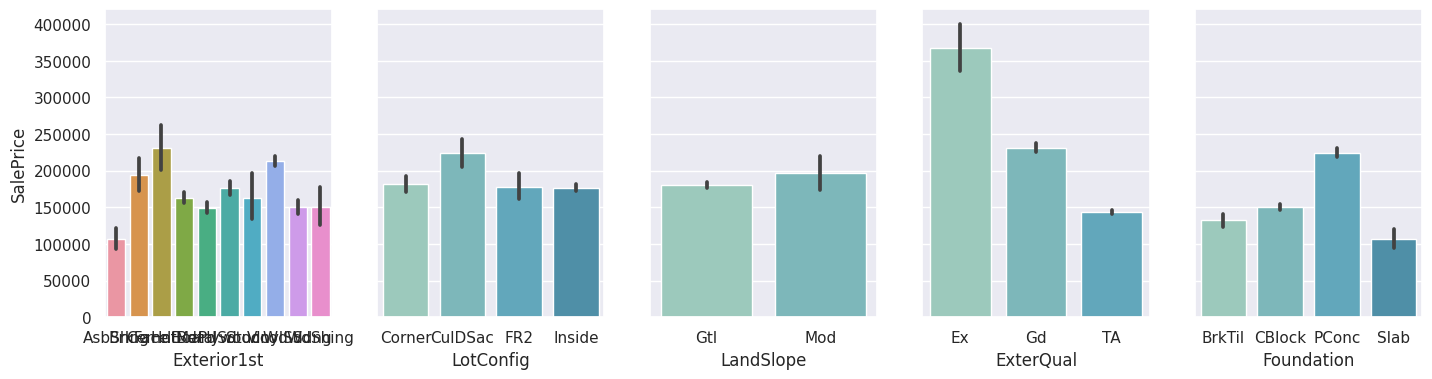

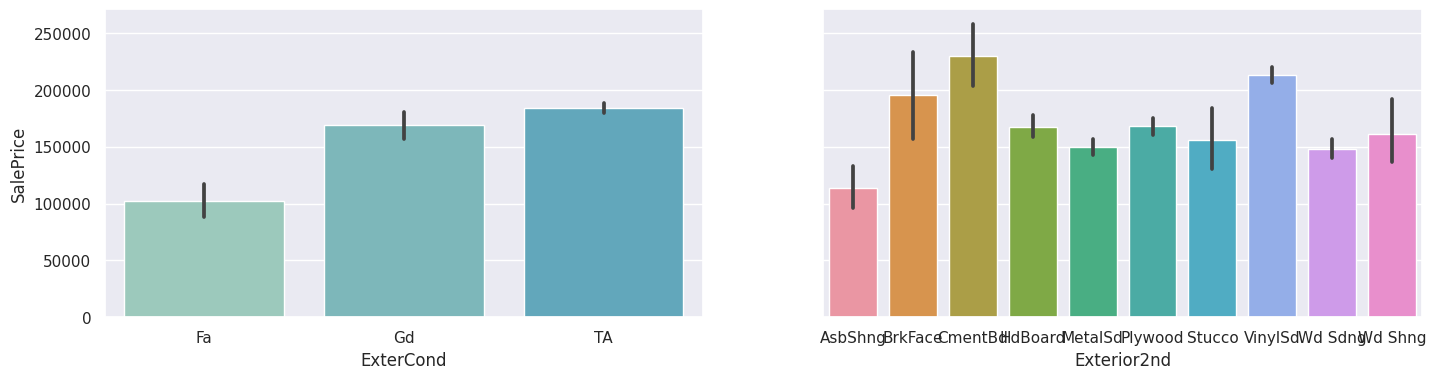

In [12]:
ds_boost.show_target_vs_categorical(df, target)

#### Numerical features

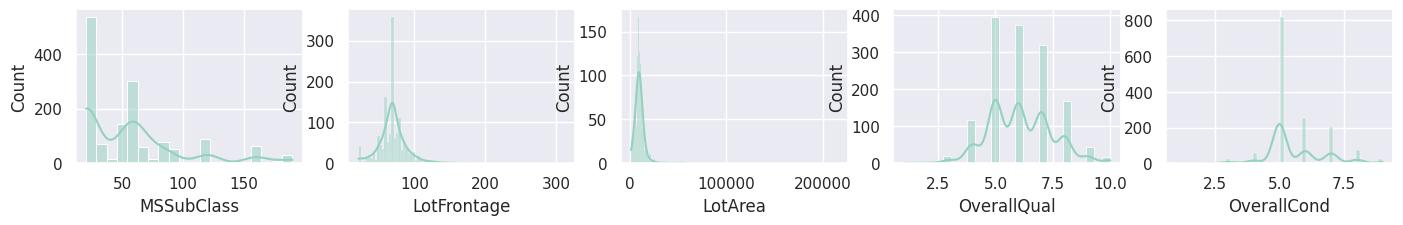

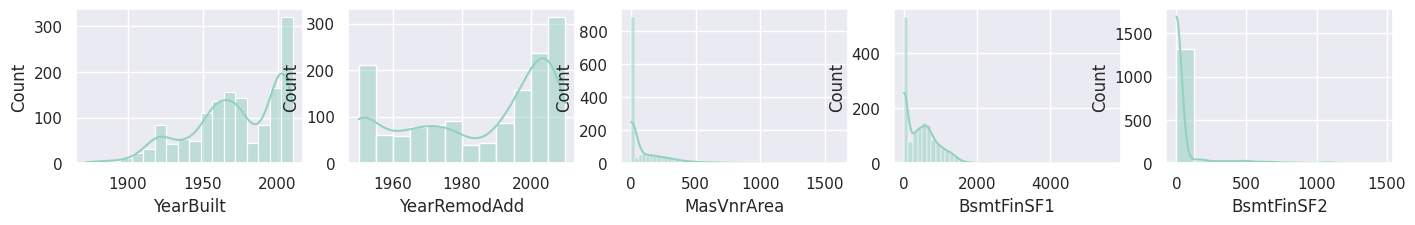

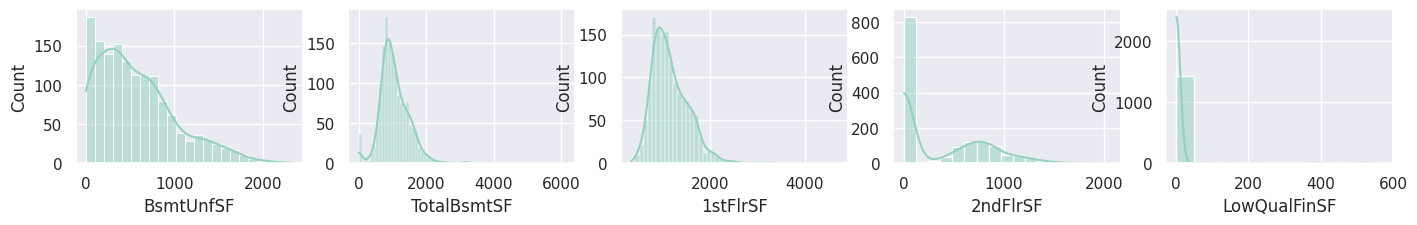

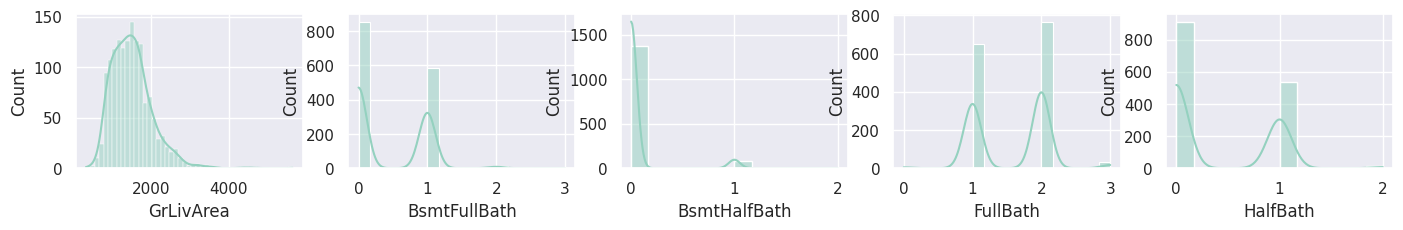

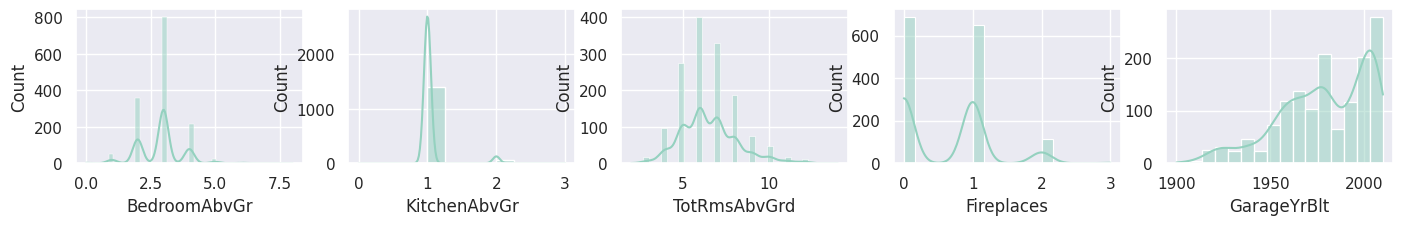

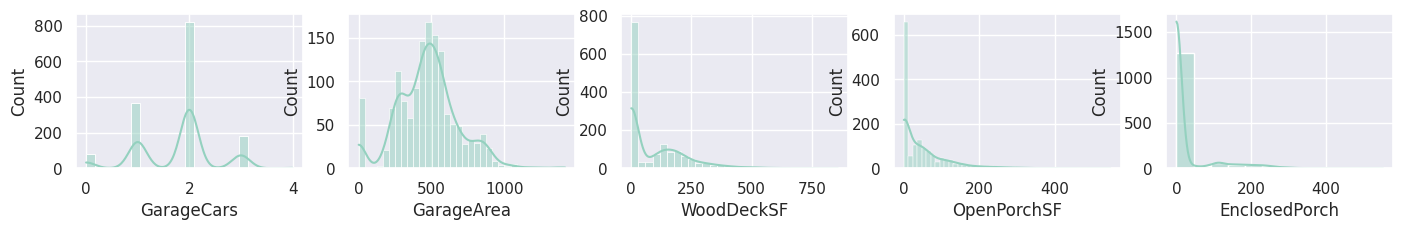

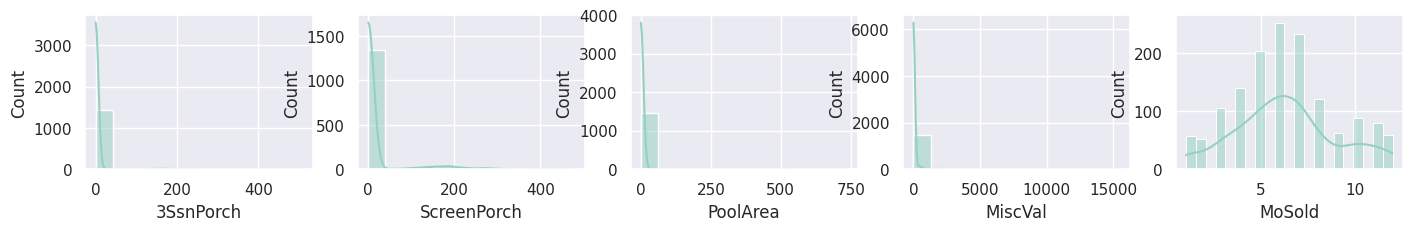

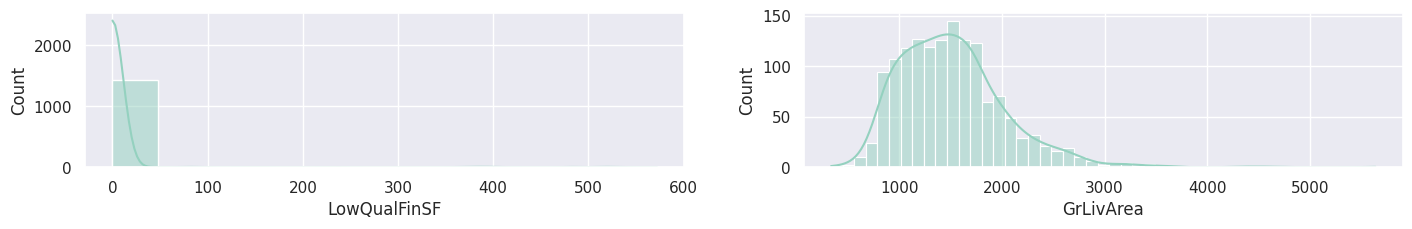

In [13]:
ds_boost.show_numerical(df, kde=True)

#### Target vs Numerical features

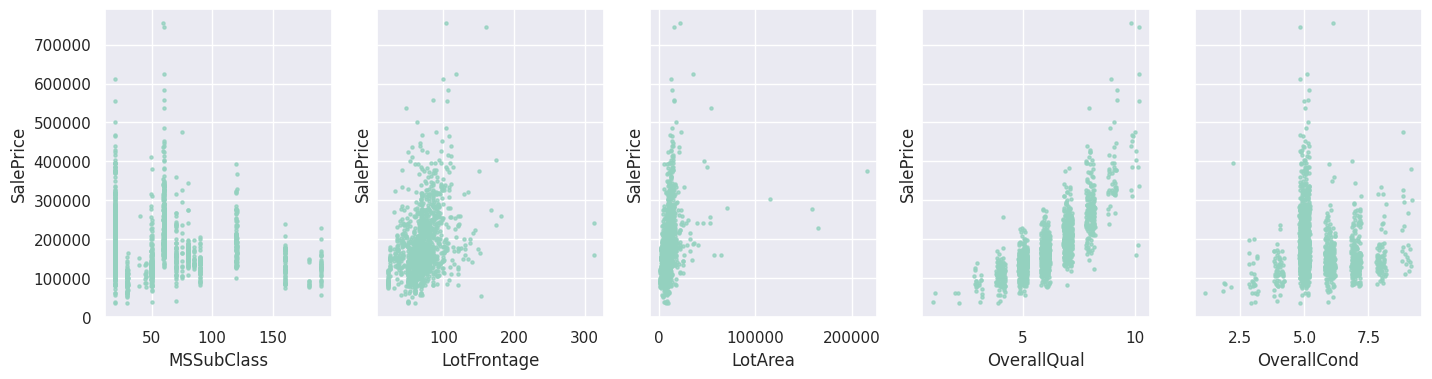

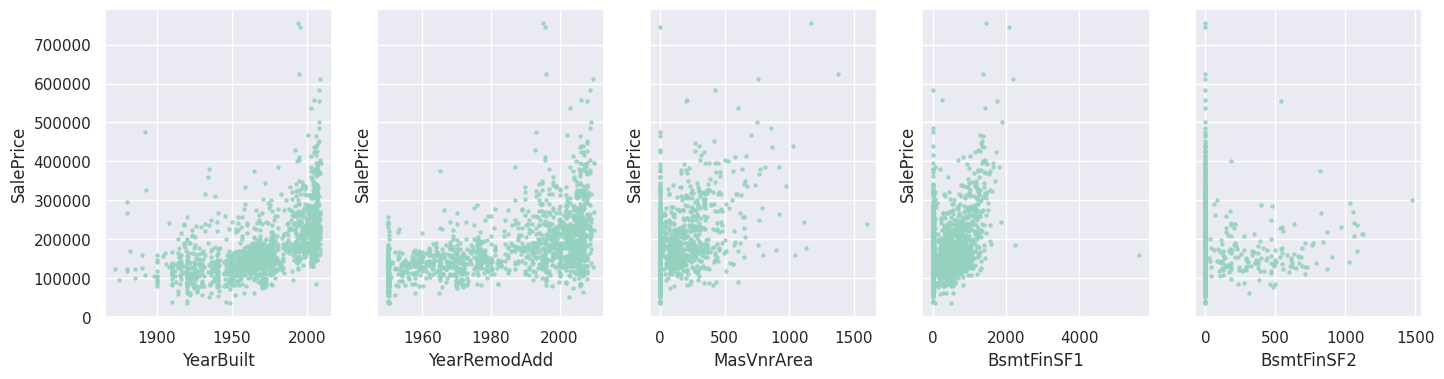

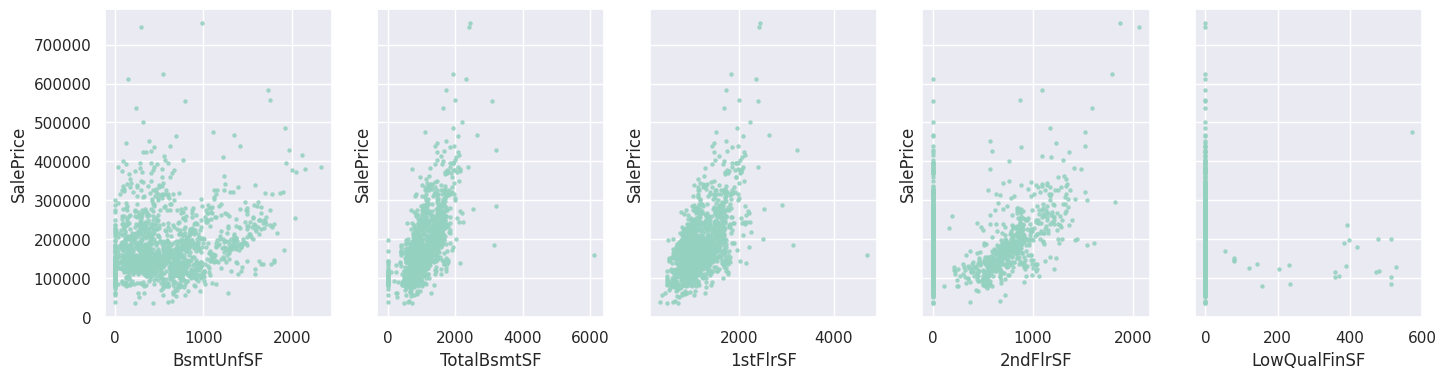

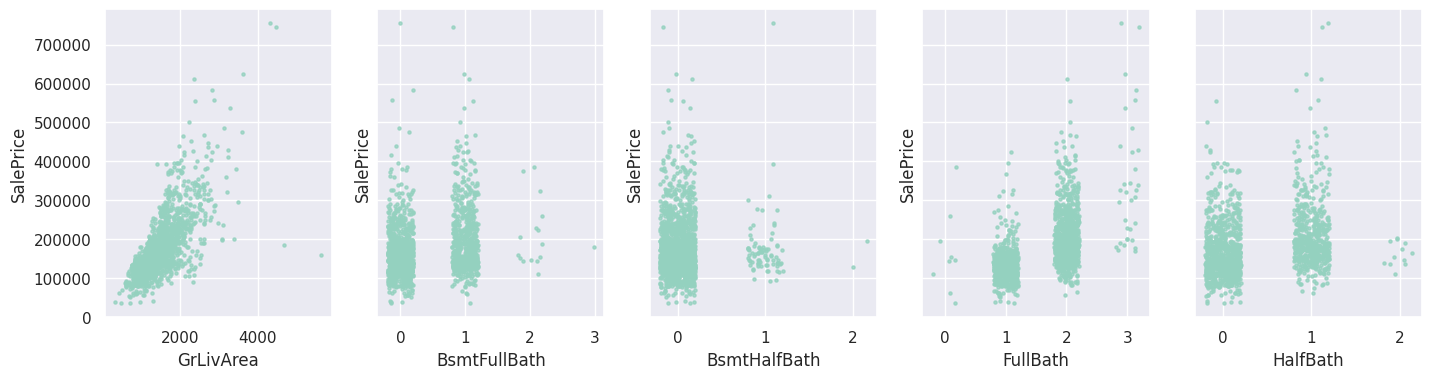

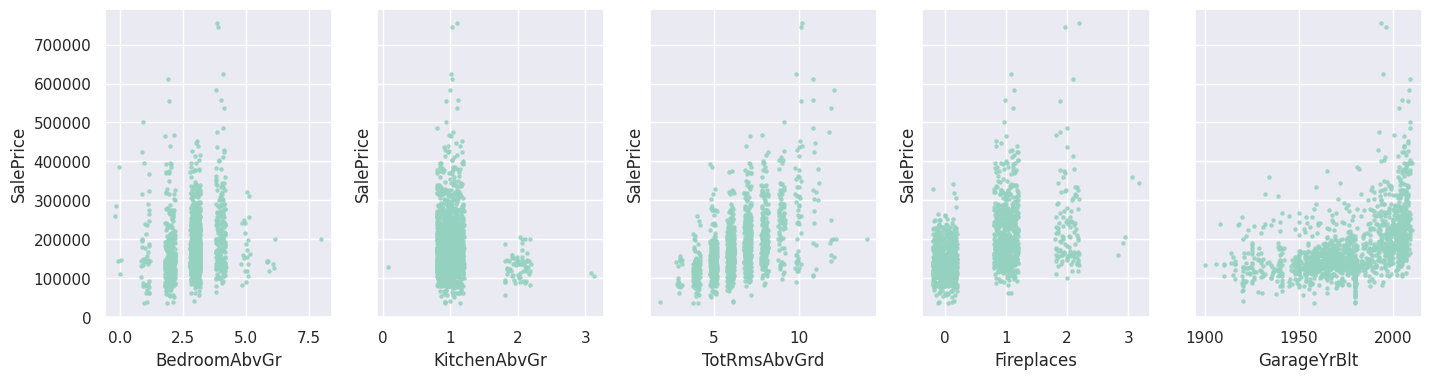

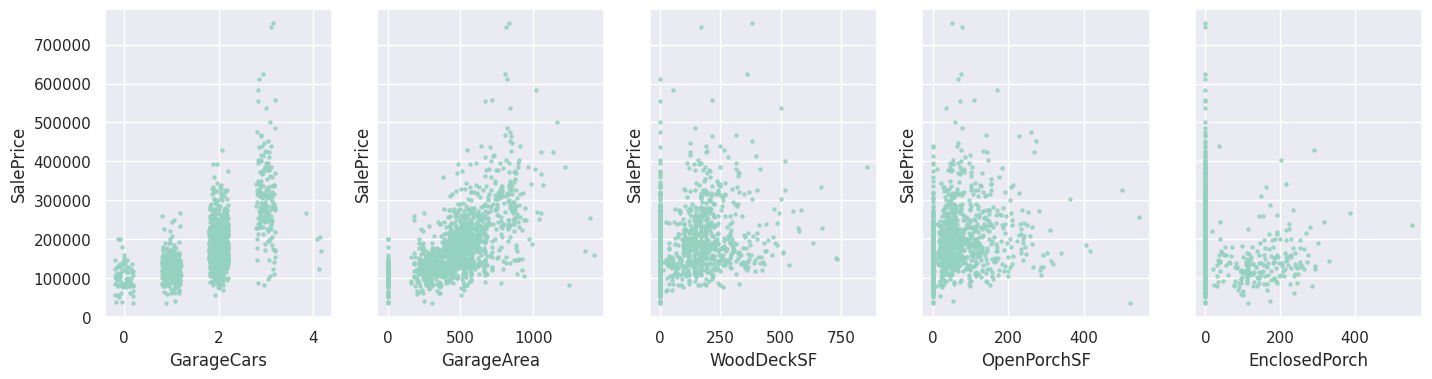

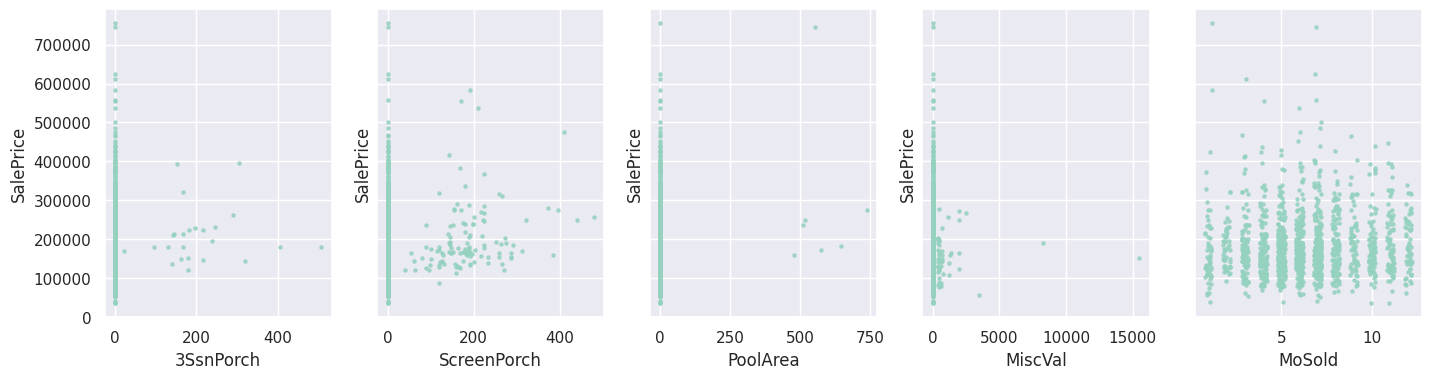

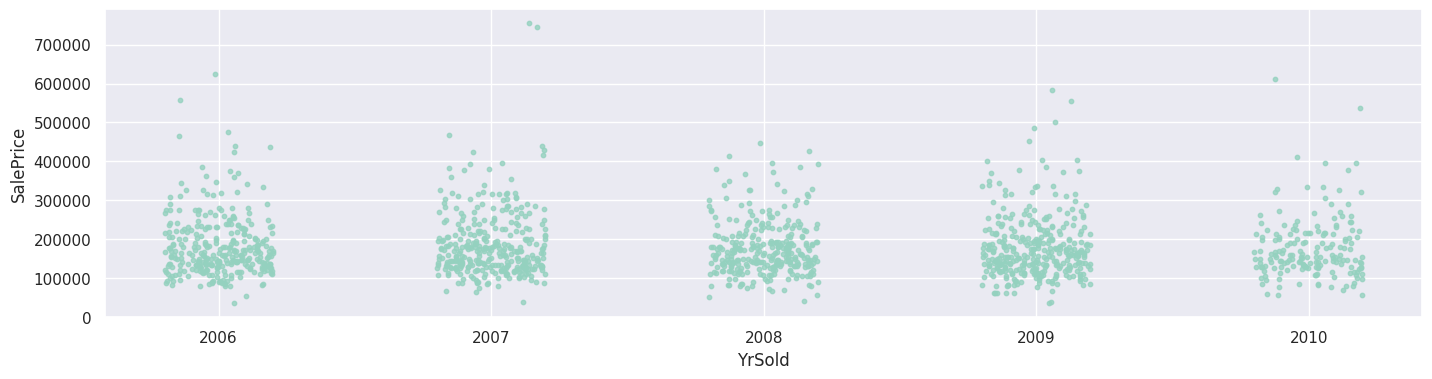

In [14]:
ds_boost.show_target_vs_numerical(df, target, point_size=20, jitter=0.2, fit_reg=False)

#### Correlation between numerical features and target

[]

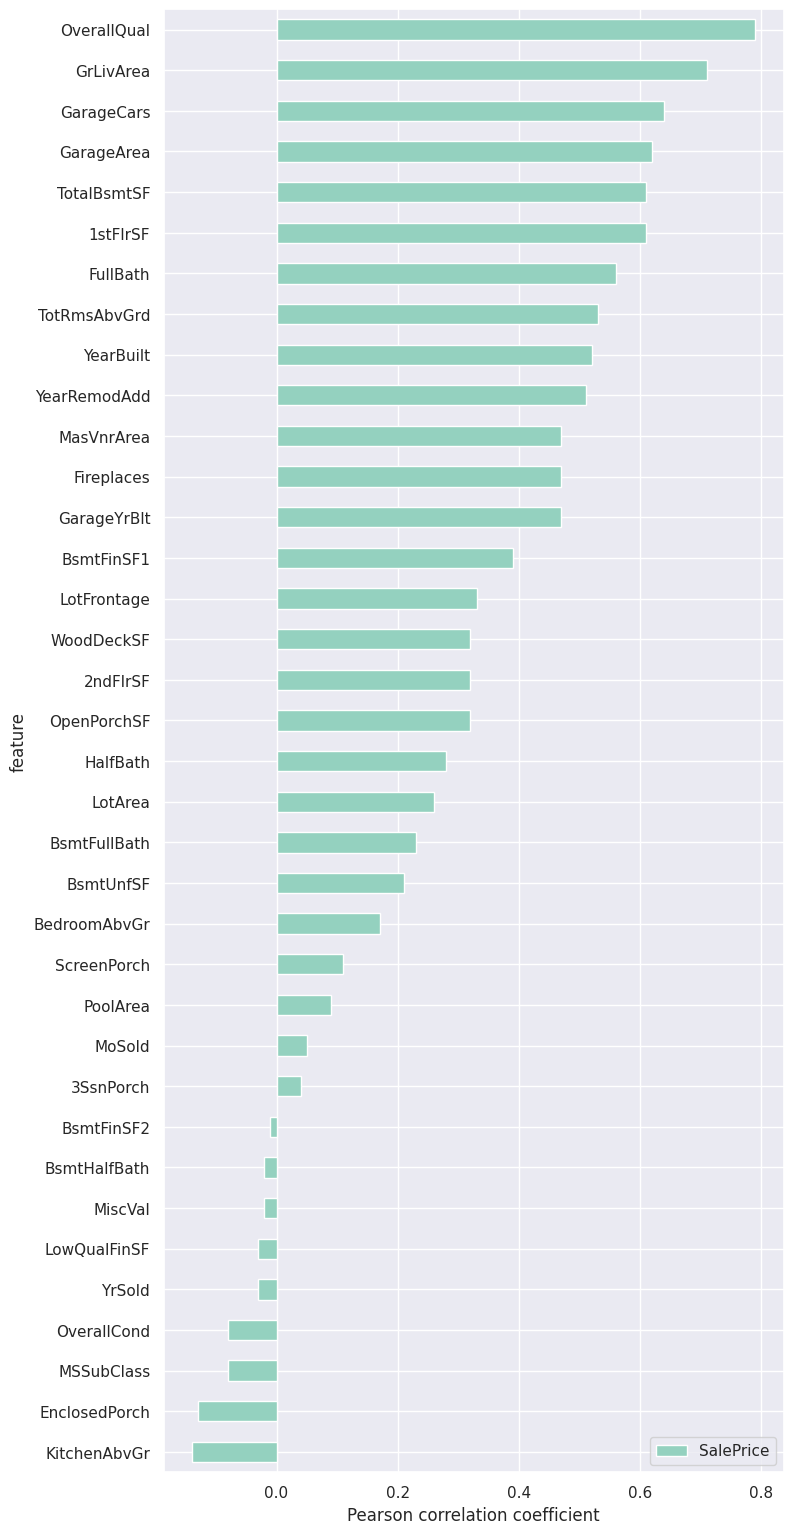

In [15]:
ds_boost.correlation(df, target)

## 2. Neural Network model

### Select the features

In [16]:
droplist = []  # features to drop

# For the model 'data' instead of 'df'
data = df.copy()
data.drop(droplist, axis="columns", inplace=True)
data.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageQual,SaleType,Exterior1st,LotConfig,LandSlope,ExterQual,Foundation,HeatingQC,BsmtQual,SalePrice
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,TA,WD,VinylSd,Inside,Gtl,Gd,PConc,Ex,Gd,208500.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,TA,WD,MetalSd,FR2,Gtl,TA,CBlock,Ex,Gd,181500.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,TA,WD,VinylSd,Inside,Gtl,Gd,PConc,Ex,Gd,223500.0


### Scale numerical variables
Shift and scale numerical variables to a standard normal distribution. The scaling factors are saved to be used for predictions.

In [17]:
data, scale_param = ds_boost.scale(data)

### Create dummy features
Replace categorical features (no target) with dummy features

In [18]:
data, dict_dummies = ds_boost.replace_by_dummies(data, target)

model_features = [f for f in data if f not in target]  # sorted neural network inputs

data.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Foundation_PConc,Foundation_Slab,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA
0,0.073350,-0.220800,-0.207071,0.651256,-0.517023,1.050633,0.878369,0.513928,0.575228,-0.288554,...,True,False,True,False,False,False,False,False,True,False
1,-0.872264,0.460162,-0.091855,-0.071812,2.178881,0.156680,-0.429428,-0.570555,1.171591,-0.288554,...,False,False,True,False,False,False,False,False,True,False
2,0.073350,-0.084607,0.073455,0.651256,-0.517023,0.984414,0.829932,0.325803,0.092875,-0.288554,...,True,False,True,False,False,False,False,False,True,False


### Split the data into training, validation, and test sets
Data leakage: Test set hidden when training the model, but seen when preprocessing the dataset

In [19]:
test_size = 0.2
val_size = 0.1
random_state = 9

x_train, y_train, x_val, y_val, x_test, y_test = ds_boost.data_split_for_ml_with_val(
    data, target, test_size=test_size, val_size=val_size, random_state=random_state
)
x_train, y_train, x_val, y_val, x_test, y_test = ds_boost.convert_to_tensors(
    (x_train, y_train, x_val, y_val, x_test, y_test)
)

20:34:40 - DEBUG 	 train size 	 X:(1051, 188) 	 Y:(1051, 1)
20:34:40 - DEBUG 	 validation size	 X:(117, 188) 	 Y:(117, 1)
20:34:40 - DEBUG 	 test size  	 X:(292, 188) 	 Y:(292, 1) 


One-hot encode the output not needed for regression

### Build and Train the Neural Network

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 94)                17766     
                                                                 
 dropout (Dropout)           (None, 94)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 95        
                                                                 
Total params: 17861 (69.77 KB)
Trainable params: 17861 (69.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
20:34:41 - DEBUG 	 Training ....
20:34:50 - DEBUG 	 time: 	 8.9 s


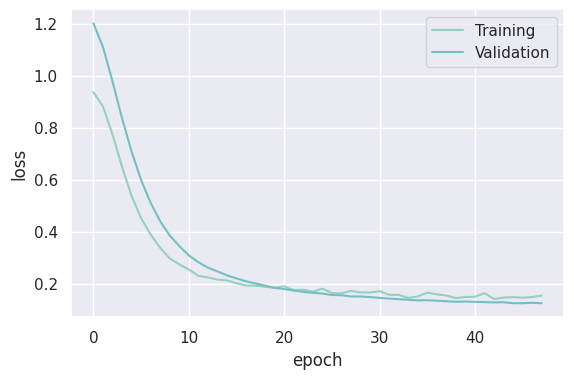

20:34:50 - DEBUG 	 Training loss:  	0.1537
20:34:50 - DEBUG 	 Validation loss: 	 0.1245
20:34:50 - DEBUG 	 Model saved at models/house_prices.h5
33/33 [==============================] - 0s 2ms/step


/home/angel/miniconda3/envs/ds-keras/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 2ms/step
Training   R2-score: 	0.864
Validation R2-score: 	0.898


In [20]:
model_path = os.path.join("models", "house_prices.h5")

weights = weights = keras.initializers.TruncatedNormal(stddev=0.0001, seed=9)
# opt = keras.optimizers.Adam(learning_rate=0.00005)

# import legacy adam
import tensorflow as tf

opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.00005)
model = None
model = ds_boost.build_nn_reg(
    x_train.shape[1],
    y_train.shape[1],
    hidden_layers=1,
    input_nodes=x_train.shape[1] // 2,
    dropout=0.2,
    kernel_initializer=weights,
    bias_initializer=weights,
    optimizer=opt,
    summary=True,
)

callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, verbose=0)]

ds_boost.train_nn(
    model,
    x_train,
    y_train,
    validation_data=[x_val, y_val],
    path=model_path,
    epochs=500,
    batch_size=16,
    callbacks=callbacks,
)

from sklearn.metrics import r2_score

ypred_train = model.predict(x_train)
ypred_val = model.predict(x_val)
print("Training   R2-score: \t{:.3f}".format(r2_score(y_train, ypred_train)))
print("Validation R2-score: \t{:.3f}".format(r2_score(y_val, ypred_val)))

### Train with Cross Validation

In [21]:
# restore training set
x_train = np.vstack((x_train, x_val))
y_train = np.vstack((y_train, y_val))

In [22]:
from sklearn.model_selection import KFold


def cv_train_nn(x_train, y_train, n_splits):
    """Create and Train models for cross validation. Return best model"""

    skf = KFold(n_splits=n_splits, shuffle=True)

    score = []

    best_model = None
    best_loss = float("inf")

    print(f"Training {n_splits} models for Cross Validation ...")

    for train, val in skf.split(x_train[:, 0], y_train[:, 0]):
        model = None
        model = ds_boost.build_nn_reg(
            x_train.shape[1],
            y_train.shape[1],
            hidden_layers=1,
            input_nodes=x_train.shape[1] // 2,
            dropout=0.2,
            kernel_initializer=weights,
            bias_initializer=weights,
            optimizer=opt,
            summary=False,
        )

        history = ds_boost.train_nn(
            model,
            x_train[train],
            y_train[train],
            show=False,
            validation_data=(x_train[val], y_train[val]),
            epochs=500,
            batch_size=16,
            callbacks=callbacks,
        )

        val_loss = history.history["val_loss"][-1]

        score.append(val_loss)

        if val_loss < best_loss:  # save best model (fold) for evaluation and predictions
            best_model = model
            best_loss = val_loss

    print("\nCross Validation loss: {:.3f}".format(np.mean(score)))
    return best_model


model = cv_train_nn(x_train, y_train, 10)

Training 10 models for Cross Validation ...

Cross Validation loss: 0.148


### Evaluate the model

In [23]:
y_pred_test = model.predict(x_test, verbose=0)
ds_boost.regression_scores(y_test, y_pred_test, return_dataframe=True, index="DNN")

,Loss,R2 Score
DNN,0.16,0.86


### Make predictions

SalePrice . Prediction error:
Mean: 	 -0.43%
Stddev:  10.80%


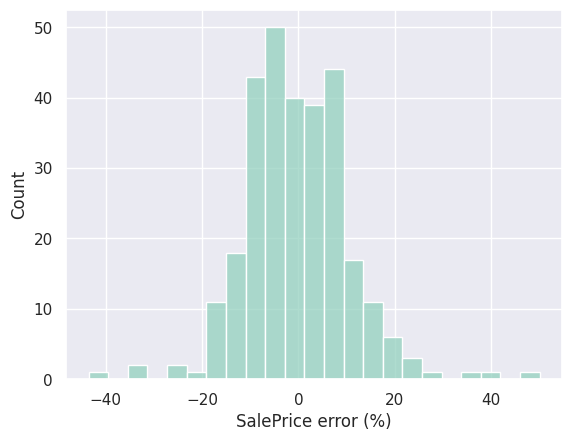

In [24]:
def predict_nn(model, x_test, target):
    """Return a dataframe with actual and predicted targets in original scale"""

    for t in target:
        pred = model.predict(x_test, verbose=0)
        restore_pred = pred * scale_param[t][1] + scale_param[t][0]
        restore_pred = restore_pred.round()

        restore_y = y_test * scale_param[t][1] + scale_param[t][0]
        restore_y = restore_y.numpy().round()

        pred_label = f"Predicted_{t}"
        error_label = f"{t} error (%)"

        pred_df = pd.DataFrame({t: np.squeeze(restore_y), pred_label: np.squeeze(restore_pred)})

        pred_df[error_label] = ((pred_df[pred_label] - pred_df[t]) * 100 / pred_df[t]).round(1)

        print(t, ". Prediction error:")
        print("Mean: \t {:.2f}%".format(pred_df[error_label].mean()))
        print("Stddev:  {:.2f}%".format(pred_df[error_label].std()))
        sns.histplot(pred_df[error_label])

    return pred_df


pred_df = predict_nn(model, x_test, target)

In [25]:
pred_df.head(10)

,SalePrice,Predicted_SalePrice,SalePrice error (%)
0,151400.0,211907.0,40.000000
1,241500.0,216436.0,-10.400000
2,82000.0,78687.0,-4.000000
3,162000.0,170711.0,5.400000
4,140000.0,143859.0,2.800000
5,227000.0,212420.0,-6.400000
6,228950.0,282203.0,23.299999
7,208300.0,191728.0,-8.000000
8,128500.0,120454.0,-6.300000
9,165000.0,174498.0,5.800000


The error of the predicted sale prices can be modeled by a normal distribution, almost zero centered, and with a standard deviation of < 12%. Thus, ~95% of the houses are predicted within a price error < 24% respect to the actual one. 

Note: there is data leakage when removing low-frequency categorical values and scaling numerical features


### Compare with classical ML

In [26]:
ds_boost.ml_regression(x_train, y_train, x_test, y_test)

20:36:03 - DEBUG 	 Linear
20:36:03 - DEBUG 	 KNeighbors
20:36:03 - DEBUG 	 Random Forest
20:36:03 - DEBUG 	 LightGBM


,Time (s),Test loss,Test R2 score
Random Forest,0.4,0.12,0.89
LightGBM,0.2,0.13,0.88
Linear,0.1,0.17,0.85
KNeighbors,0.0,0.29,0.74


####  Best tree-based model

In [27]:
from lightgbm import LGBMRegressor

model = LGBMRegressor(n_jobs=-1, n_estimators=50, max_depth=17, random_state=9).fit(x_train, np.ravel(y_train))

y_pred = model.predict(x_test)

ds_boost.regression_scores(y_test, y_pred, return_dataframe=True, index="LGBM")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3185
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 169
[LightGBM] [Info] Start training from score -0.027285
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] A

,Loss,R2 Score
LGBM,0.14,0.88


#### Feature importance

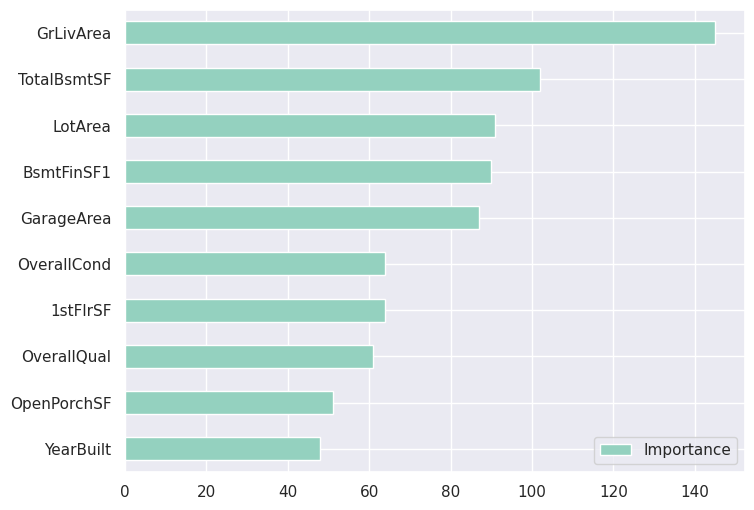

In [28]:
results = ds_boost.feature_importance(model_features, model)